<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F3D8F5;">

# What is the inhibitory connectivity underlying surround suppression in the mouse primary visual cortex?

## Background
Surround suppression is a feature of sensory processing which, in visual systems, facilitates the definition of objects against their backgrounds (Kiniklioglu & Kaiser, 2025) by sharpening receptive fields as suppression strength increases (Plomp et al., 2019). While much work has been directed to describing the functional aspect of surround suppression, the underlying inhibitory structural connectivity has received less attention. We propose the use of the V1DD dataset, which comprises both structural and functional data, to address several questions about the inhibitory connectivity subserving surround suppression across the layers of the mouse primary visual cortex. 
    
## Methods
### Feature extraction:
Morphological metrics: total axonal length/radius, branch counts, maximum branch order, output synapse counts, synaptic density per unit length, number of distinct target types, layer/radial distributions, soma depth
Activity metrics: Differences in ΔF/F for windowed gabor - full-field gabor, suppression index
Synapse spatial targeting: Comparison of SOM+ vs other inhibitory interneurons for probability of synapsing
    
## Statistics:
Make a null connectivity model (by shuffling connections between cells): If the cell is connected to the inhibitory cells, then this cell may be more functionally capable of doing surround suppression, and the cells that could have been connected to inhibitory cells, will be less capable. Whether this is actually the case is unclear, and making a null connectivity model will help with this question.
Spearman correlation for cell connectivity probabilities? Maybe could do paired tests, depends on the final form of data.


In [1]:
# Import packages
import sys
import os
from os.path import join as pjoin
import platform

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from standard_transform.datasets import v1dd_ds

# Add the directory for the data and utilities
mat_version = 1196

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_root = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2025/"

# Set the directory to load prepared data and utility code
data_dir = pjoin(data_root, f"v1dd_{mat_version}")
utils_dir = pjoin("..", "utils")

# Add utilities to path
sys.path.append(utils_dir)
from data_io import *
from utils import filter_synapse_table, check_index, adjacencyplot, calculate_lateral_distances
from data_io import _get_data_dir

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">
Load proofreading information about cells:
</div>

In [2]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_dendrite_list_{mat_version}.npy")
)
axon_proof_root_ids = np.load(pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

proofread_ids = np.intersect1d(dendrite_proof_root_ids, axon_proof_root_ids)

proofread_ids

array([864691132534275418, 864691132534315610, 864691132535664474, ...,
       864691133313558608, 864691133313636944, 864691133313665616],
      shape=(1148,))

In [3]:
# Load synapses 
# syn_df = syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")
syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather"
).set_index("id")

# Load target information
target_structure = pd.read_feather(
    pjoin(data_dir, f"syn_label_df_all_to_proofread_to_all_{mat_version}.feather")
)["tag"]

# Combine the target information to the proofread synapses table
syn_df["target_structure"] = target_structure
syn_df["target_structure"] = syn_df["target_structure"].fillna("unknown")
syn_df.head()


,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,target_structure
id,,,,,,,,,,,,,
354386968,758200.5,802316.1,304380.0,757861.0,802558.6,304650.0,757967.7,802597.4,304380.0,240,864691132536286810,864691132734919083,shaft
378070488,792063.2,514342.5,183735.0,792664.6,514284.3,183915.0,792412.4,514294.0,183735.0,3056,864691132572190492,864691132606767301,shaft
499493001,977071.3,390075.8,191340.0,976974.3,390104.9,190935.0,976838.5,390337.7,190935.0,1346,864691132573738810,864691132747578447,unknown
119675985,444260.0,602544.6,3285.0,443988.4,602311.8,3555.0,444182.4,602370.0,3780.0,3637,864691132572564252,864691132654028028,unknown
220616943,574501.9,337249.6,258570.0,574152.7,337016.8,258570.0,574337.0,336900.4,258570.0,420,864691132558380553,864691132828255906,unknown


In [4]:
# filter synapses between proofread cells

proof_syn_df = filter_synapse_table(syn_df, proofread_ids, proofread_ids)

# we're going to copy proof_syn_df to avoid modifying the original DataFrame -
# pandas will often yell at you if you try to modify a DataFrame that is a view of
# another DataFrame
proof_syn_df = proof_syn_df.copy()

proof_syn_df.head()

,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,target_structure
id,,,,,,,,,,,,,
461895313,917998.3,772740.8,284220.0,918376.6,772818.4,283815.0,918202.0,773080.3,284085.0,540,864691132557909513,864691132931817448,shaft
301049004,679950.6,813121.9,283050.0,679552.9,812753.3,283095.0,679601.4,812782.4,283140.0,958,864691132578625044,864691132931817448,shaft
436596114,879663.9,750576.3,347715.0,879266.2,750653.9,348120.0,879469.9,750634.5,347940.0,266,864691132557909513,864691132931817448,shaft
363374679,781538.7,726132.3,241110.0,781257.4,726268.1,240480.0,781305.9,725986.8,240705.0,396,864691132578625044,864691132786109590,shaft
491726200,962385.5,676759.3,316035.0,962210.9,677069.7,316620.0,962366.1,676856.3,316305.0,442,864691132562471396,864691132773784759,shaft


In [5]:
# Mark proofread neurons in the synapse dataframe so we can filter out everything else for connectivity analysis
proof_syn_df["pre_proofread"] = proof_syn_df["pre_pt_root_id"].isin(proofread_ids)
proof_syn_df["post_proofread"] = proof_syn_df["post_pt_root_id"].isin(proofread_ids)

# These are approximate depth values in post-transformed microns for the pial surface, L1-L2/3 border, L2/3-L4 border, etc. down to the L6-wm border.
layer_bounds = [
    -15,
    91,
    261,
    391,
    537,
    753,
]  

In [6]:
# load the cell type information
ct_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

# Convert from nanometers to microns
ct_df["soma_depth"] = (
    ct_df["pt_position_trform_y"] / 1_000
)  

# Approximate cell depth from pial surface in microns
ct_df["pt_position_trform_x"] =ct_df["pt_position_trform_x"] / 1_000
ct_df["pt_position_trform_y"] =ct_df["pt_position_trform_y"] / 1_000
ct_df["pt_position_trform_z"] =ct_df["pt_position_trform_z"] / 1_000

ct_df.head() 

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type,soma_depth
0,228132,632828,749849,738270,-323.721448,549.910283,392.909833,864691132737039043,458.464831,None,None,549.910283
1,543247,1304922,977915,83880,330.339020,595.962276,-306.424551,864691132730839988,73.345940,None,None,595.962276
2,203262,624680,531094,283770,-252.082628,203.770728,21.544030,864691132654552792,338.276613,E,L3-IT,203.770728
3,350562,894573,478559,163530,20.989259,117.514626,-98.554035,864691132773514104,326.965400,E,L2-IT,117.514626
4,718122,1729859,674111,781200,803.635727,475.075415,467.669881,864691132774106773,333.888647,None,None,475.075415


In [7]:
# What we are about to do requres that no root ids are duplicated in this, so let's double check:
ct_df.drop_duplicates("pt_root_id", keep=False, inplace=True)

In [8]:
# Add proofreading information
ct_df["is_proofread"] = ct_df["pt_root_id"].isin(proofread_ids)
ct_df.head(5)

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type,soma_depth,is_proofread
2,203262,624680,531094,283770,-252.082628,203.770728,21.544030,864691132654552792,338.276613,E,L3-IT,203.770728,False
3,350562,894573,478559,163530,20.989259,117.514626,-98.554035,864691132773514104,326.965400,E,L2-IT,117.514626,False
4,718122,1729859,674111,781200,803.635727,475.075415,467.669881,864691132774106773,333.888647,None,None,475.075415,False
5,680726,1640231,677370,768015,713.993992,475.136490,454.028344,864691132780109973,706.847075,None,None,475.136490,False
6,544582,1316562,974035,157590,334.827644,613.565716,-236.450684,864691132736203675,200.069363,None,None,613.565716,False


In [9]:
# Add the synapse depth in consistent coordinates
proof_syn_df["synapse_depth"] = v1dd_ds.transform_nm.apply_dataframe(
    "ctr_pt_position", proof_syn_df, projection="y"
)

proof_syn_df.head(5)

,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,post_pt_position_x,post_pt_position_y,post_pt_position_z,ctr_pt_position_x,ctr_pt_position_y,ctr_pt_position_z,size,pre_pt_root_id,post_pt_root_id,target_structure,pre_proofread,post_proofread,synapse_depth
id,,,,,,,,,,,,,,,,
461895313,917998.3,772740.8,284220.0,918376.6,772818.4,283815.0,918202.0,773080.3,284085.0,540,864691132557909513,864691132931817448,shaft,True,True,431.064281
301049004,679950.6,813121.9,283050.0,679552.9,812753.3,283095.0,679601.4,812782.4,283140.0,958,864691132578625044,864691132931817448,shaft,True,True,470.251715
436596114,879663.9,750576.3,347715.0,879266.2,750653.9,348120.0,879469.9,750634.5,347940.0,266,864691132557909513,864691132931817448,shaft,True,True,426.723685
363374679,781538.7,726132.3,241110.0,781257.4,726268.1,240480.0,781305.9,725986.8,240705.0,396,864691132578625044,864691132786109590,shaft,True,True,374.759254
491726200,962385.5,676759.3,316035.0,962210.9,677069.7,316620.0,962366.1,676856.3,316305.0,442,864691132562471396,864691132773784759,shaft,True,True,346.758021


In [10]:
# add the postsynaptic euclidean distance from the presynaptic cell/neuron

def add_euclidean_distance(df, x1='x1', x2='x2',y1='y1', y2='y2',z1='z1', z2='z2', new_col='distance'):
    """
    Calculate Euclidean distance from origin (0,0,0) for x, y, z coordinates in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing x, y, z coordinate columns.
    x_col, y_col, z_col : str
        Names of the columns for x, y, z coordinates.
    new_col : str
        Name of the new column to store distances.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with an additional column containing Euclidean distances.
    """
    x_col = x1-x2
    y_col = y1-y2 
    z_col = z1-z2
    df[new_col] = np.sqrt(df[x_col]**2 + df[y_col]**2 + df[z_col]**2)
    return df


In [11]:
# Let's make a dataframe where each row is a "connection" between a presynaptic and postsynaptic neuron, with the number of synapses and their summed size as two different measures of the connection weight.
# This involves a "group-by" on both the presynaptic and postsynaptic neuron IDs and aggregating both the count of synapses, summed synapse size, average euclidean distance.

connectivity_df = (
    proof_syn_df.query("pre_proofread and post_proofread")
    .groupby(["pre_pt_root_id", "post_pt_root_id","target_structure"])
    .agg(num_synapses=("pre_pt_root_id", "count"), sum_size=("size", "sum"))
    .reset_index()
)

connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,target_structure,num_synapses,sum_size
0,864691132534275418,864691132619649223,shaft,1,2620
1,864691132534275418,864691132656860272,shaft,1,898
2,864691132534275418,864691132659029623,shaft,3,3828
3,864691132534275418,864691132663192644,spine,1,4488
4,864691132534275418,864691132663898692,shaft,1,1556


In [12]:
# add the synaptic ratio - divide sum_size by number of synapses
connectivity_df["synaptic_ratio"] = connectivity_df["sum_size"]/connectivity_df["num_synapses"]
connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,target_structure,num_synapses,sum_size,synaptic_ratio
0,864691132534275418,864691132619649223,shaft,1,2620,2620.0
1,864691132534275418,864691132656860272,shaft,1,898,898.0
2,864691132534275418,864691132659029623,shaft,3,3828,1276.0
3,864691132534275418,864691132663192644,spine,1,4488,4488.0
4,864691132534275418,864691132663898692,shaft,1,1556,1556.0


In [13]:
# Swap column 'synaptic_ratio' to the fourth position
# col = connectivity_df.pop('synaptic_ratio')
# connectivity_df.insert(5, 'synaptic_ratio', col)

#Swap columns
connectivity_df = connectivity_df[['pre_pt_root_id', 'post_pt_root_id', 'num_synapses',
                                  'sum_size', 'synaptic_ratio','target_structure']]

#col2 = connectivity_df.pop('target_structure')
#connectivity_df.insert(6,'target_structure', col2)

connectivity_df.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,target_structure
0,864691132534275418,864691132619649223,1,2620,2620.0,shaft
1,864691132534275418,864691132656860272,1,898,898.0,shaft
2,864691132534275418,864691132659029623,3,3828,1276.0,shaft
3,864691132534275418,864691132663192644,1,4488,4488.0,spine
4,864691132534275418,864691132663898692,1,1556,1556.0,shaft


In [14]:
# Merge with the cell type dataframe

connectivity_ct_df = connectivity_df.merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type",
          "pt_position_trform_x", "pt_position_trform_y", "pt_position_trform_z"]].rename(
        columns={
            "pt_root_id": "pre_pt_root_id",
            "soma_depth": "soma_depth_pre",
            "cell_type": "cell_type_pre",
            "cell_type_coarse": "ei_pre",
            "pt_position_trform_x": "pre_pt_position_trform_x",
            "pt_position_trform_y": "pre_pt_position_trform_y",
            "pt_position_trform_z": "pre_pt_position_trform_z",
        }
    ),
    on="pre_pt_root_id",
).merge(
    ct_df[["pt_root_id", "soma_depth", "cell_type_coarse", "cell_type",
          "pt_position_trform_x", "pt_position_trform_y", "pt_position_trform_z"]].rename(
        columns={
            "pt_root_id": "post_pt_root_id",
            "soma_depth": "soma_depth_post",
            "cell_type": "cell_type_post",
            "cell_type_coarse": "ei_post",
            "pt_position_trform_x": "post_pt_position_trform_x",
            "pt_position_trform_y": "post_pt_position_trform_y",
            "pt_position_trform_z": "post_pt_position_trform_z",
        }
    ),
    on="post_pt_root_id",
)

connectivity_ct_df.head(10)


,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,target_structure,soma_depth_pre,ei_pre,cell_type_pre,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,soma_depth_post,ei_post,cell_type_post,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z
0,864691132534275418,864691132619649223,1,2620,2620.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,448.697962,I,DTC,-43.506347,448.697962,-10.484903
1,864691132534275418,864691132656860272,1,898,898.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,357.350410,I,DTC,-193.548967,357.350410,15.140193
2,864691132534275418,864691132659029623,3,3828,1276.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,349.799057,I,DTC,-122.243544,349.799057,14.003278
3,864691132534275418,864691132663192644,1,4488,4488.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,480.704383,E,L5-ET,-125.287543,480.704383,-41.081802
4,864691132534275418,864691132663898692,1,1556,1556.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,623.202753,I,PTC,-82.777616,623.202753,-18.222546
5,864691132534275418,864691132666054744,1,4965,4965.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,465.692836,E,L5-ET,-128.831488,465.692836,-19.084771
6,864691132534275418,864691132689698824,1,1436,1436.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,420.092290,I,DTC,-79.689835,420.092290,97.424968
7,864691132534275418,864691132700001158,1,631,631.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,427.743622,E,L5-ET,-113.338277,427.743622,54.040920
8,864691132534275418,864691132714139653,1,270,270.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,480.999345,I,DTC,-118.093285,480.999345,-49.544900
9,864691132534275418,864691132739485851,1,3425,3425.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,436.666528,E,L5-ET,-23.587578,436.666528,61.123783


In [15]:
def calculate_euclidean_distance(df, x1_col, y1_col, z1_col, x2_col, y2_col, z2_col, new_col="distance"):
    """
    Calculates the Euclidean distance between (x1, y1, z1) and (x2, y2, z2) for each row in a DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing coordinate columns.
    x1_col, y1_col, z1_col : str
        Column names for the first set of coordinates.
    x2_col, y2_col, z2_col : str
        Column names for the second set of coordinates.
    new_col : str, optional (default="distance")
        Name of the new column to store calculated distances.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with an additional column containing Euclidean distances.
    """
    df[new_col] = np.sqrt(
        (df[x2_col] - df[x1_col])**2 +
        (df[y2_col] - df[y1_col])**2 +
        (df[z2_col] - df[z1_col])**2
    )
    return df

In [16]:
# compute the euclidean distance for each post_pt_root_id
connectivity_ct_df_ecldn = calculate_euclidean_distance(connectivity_ct_df, x1_col ='post_pt_position_trform_x', y1_col ='post_pt_position_trform_y', z1_col='post_pt_position_trform_z',
                                      x2_col='pre_pt_position_trform_x', y2_col ='pre_pt_position_trform_y', z2_col ='pre_pt_position_trform_z',new_col='euclidean_distance')
connectivity_ct_df_ecldn.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,target_structure,soma_depth_pre,ei_pre,cell_type_pre,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,soma_depth_post,ei_post,cell_type_post,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,euclidean_distance
0,864691132534275418,864691132619649223,1,2620,2620.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,448.697962,I,DTC,-43.506347,448.697962,-10.484903,179.356591
1,864691132534275418,864691132656860272,1,898,898.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,357.350410,I,DTC,-193.548967,357.350410,15.140193,66.884140
2,864691132534275418,864691132659029623,3,3828,1276.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,349.799057,I,DTC,-122.243544,349.799057,14.003278,52.734229
3,864691132534275418,864691132663192644,1,4488,4488.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,480.704383,E,L5-ET,-125.287543,480.704383,-41.081802,187.619025
4,864691132534275418,864691132663898692,1,1556,1556.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,623.202753,I,PTC,-82.777616,623.202753,-18.222546,322.189263


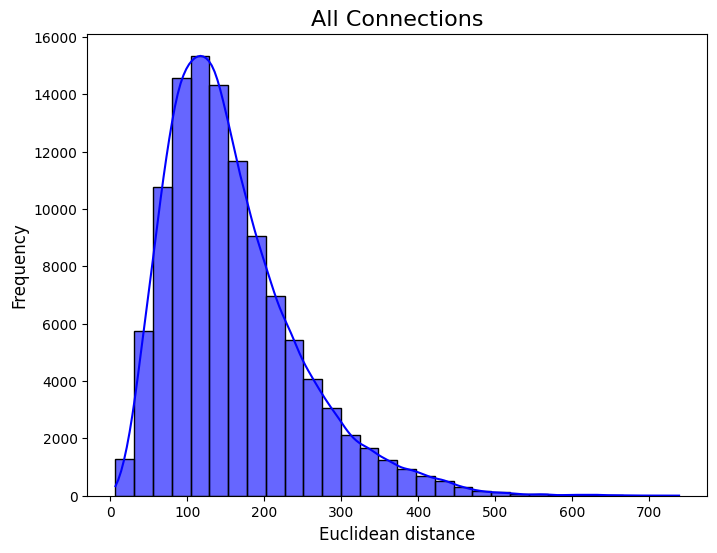

In [17]:
#Visualize euclidean distance distribution
#connectivity_ct_df_ecldn['euclidean_distance'].plot.hist(bins=5, color='orange', edgecolor='black')

plt.figure(figsize=(8, 6))
sns.histplot(connectivity_ct_df_ecldn['euclidean_distance'], kde=True, bins=30, color='blue', alpha=0.6, edgecolor='black')

# Show the plot
# Add labels and title
plt.title('All Connections', fontsize=16)
plt.xlabel('Euclidean distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Save the figure as a PNG file
plt.savefig(f"/results/elcdn_all_proofreadAll.png", dpi=300)

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

#### I to E connections


In [18]:
# find I to E connections

connectivity_ct_IE = connectivity_ct_df.query('ei_pre == "I" and ei_post == "E"')
connectivity_ct_IE.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,target_structure,soma_depth_pre,ei_pre,cell_type_pre,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,soma_depth_post,ei_post,cell_type_post,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,euclidean_distance
90,864691132536286810,864691132563376846,1,231,231.0,spine,481.95328,I,DTC,-68.294259,481.95328,-64.04816,534.001457,E,L5-NP,-69.958181,534.001457,-62.223373,52.106729
93,864691132536286810,864691132596046903,1,702,702.0,spine,481.95328,I,DTC,-68.294259,481.95328,-64.04816,448.928478,E,L5-ET,6.323069,448.928478,-0.359977,103.511197
94,864691132536286810,864691132598805055,1,415,415.0,shaft,481.95328,I,DTC,-68.294259,481.95328,-64.04816,167.400869,E,L2-IT,2.528247,167.400869,22.892389,333.942668
95,864691132536286810,864691132606072261,1,240,240.0,shaft,481.95328,I,DTC,-68.294259,481.95328,-64.04816,420.578933,E,L5-NP,20.049448,420.578933,-101.379977,113.864330
96,864691132536286810,864691132606660376,5,5614,1122.8,shaft,481.95328,I,DTC,-68.294259,481.95328,-64.04816,415.773718,E,L5-ET,-60.747868,415.773718,-38.076375,71.492769


In [19]:
connectivity_ct_IE["cell_type_post"].value_counts()

cell_type_post
L3-IT    20275
L5-ET     9445
L2-IT     8238
L4-IT     5421
L5-IT     3948
L6-IT     1937
L6-CT     1531
L5-NP      549
Name: count, dtype: int64

In [20]:
connectivity_ct_IE["cell_type_pre"].value_counts()

cell_type_pre
PTC    25422
DTC    21760
STC     2918
ITC     1244
Name: count, dtype: int64

In [21]:
'''
# Count the number of each inhibtory presynaaptic cell type connection

# query dataframe to count the number of inhibitory cell connections
queried_connectivity_ct_EI = (
    connectivity_ct_IE.groupby(["post_pt_root_id","ei_pre","ei_post","cell_type_pre", "cell_type_post","target_structure"])
    .agg(num_connections=("cell_type_pre", "count"),
         total_synapses=("num_synapses", "sum"),
         sum_size = ("sum_size", "sum"),
         #syn_ratio = ("synaptic_ratio", "mean"),
         avg_eucl_dist = ("euclidean_distance", "mean")
         )
    .reset_index()  
)

queried_connectivity_ct_EI.head()
'''

'\n# Count the number of each inhibtory presynaaptic cell type connection\n\n# query dataframe to count the number of inhibitory cell connections\nqueried_connectivity_ct_EI = (\n    connectivity_ct_IE.groupby(["post_pt_root_id","ei_pre","ei_post","cell_type_pre", "cell_type_post","target_structure"])\n    .agg(num_connections=("cell_type_pre", "count"),\n         total_synapses=("num_synapses", "sum"),\n         sum_size = ("sum_size", "sum"),\n         #syn_ratio = ("synaptic_ratio", "mean"),\n         avg_eucl_dist = ("euclidean_distance", "mean")\n         )\n    .reset_index()  \n)\n\nqueried_connectivity_ct_EI.head()\n'

In [22]:
len(connectivity_ct_IE)

51344

In [23]:
# count unique post_opt_root_ids
connectivity_ct_IE['post_pt_root_id'].value_counts()

post_pt_root_id
864691132669405014    253
864691132734343191    238
864691132688867336    217
864691132848998867    214
864691132830244868    207
                     ... 
864691132657657463      7
864691132786939218      5
864691132702645394      5
864691132781219967      2
864691132731452144      2
Name: count, Length: 674, dtype: int64

In [24]:
connectivity_ct_IE['post_pt_root_id'].unique()

array([864691132563376846, 864691132596046903, 864691132598805055,
       864691132606072261, 864691132606660376, 864691132608140569,
       864691132613539645, 864691132644003126, 864691132649386919,
       864691132655360252, 864691132656139260, 864691132657942744,
       864691132663192644, 864691132663800900, 864691132666054744,
       864691132669656346, 864691132670830031, 864691132672005146,
       864691132682319663, 864691132683942600, 864691132684814532,
       864691132685186469, 864691132685582532, 864691132689966614,
       864691132690620182, 864691132690646038, 864691132691044586,
       864691132692478968, 864691132695096809, 864691132710501931,
       864691132710866437, 864691132713507077, 864691132714014725,
       864691132717149199, 864691132720003059, 864691132725878426,
       864691132729719982, 864691132731780403, 864691132732388891,
       864691132734343191, 864691132739485851, 864691132741826140,
       864691132742621593, 864691132755400820, 864691132755677

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

#### E to I connections


In [25]:
# find E to I connections

connectivity_ct_EI = connectivity_ct_df.query('ei_pre == "E" and ei_post == "I"')
connectivity_ct_EI.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,target_structure,soma_depth_pre,ei_pre,cell_type_pre,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,soma_depth_post,ei_post,cell_type_post,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,euclidean_distance
0,864691132534275418,864691132619649223,1,2620,2620.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,448.697962,I,DTC,-43.506347,448.697962,-10.484903,179.356591
1,864691132534275418,864691132656860272,1,898,898.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,357.350410,I,DTC,-193.548967,357.350410,15.140193,66.884140
2,864691132534275418,864691132659029623,3,3828,1276.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,349.799057,I,DTC,-122.243544,349.799057,14.003278,52.734229
4,864691132534275418,864691132663898692,1,1556,1556.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,623.202753,I,PTC,-82.777616,623.202753,-18.222546,322.189263
6,864691132534275418,864691132689698824,1,1436,1436.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,420.092290,I,DTC,-79.689835,420.092290,97.424968,139.574497


In [26]:
# Keep only matching IDs
A,B = connectivity_ct_IE.copy(), connectivity_ct_EI.copy()

matching_root_ids = A[A["post_pt_root_id"].isin(B["pre_pt_root_id"])]["post_pt_root_id"].unique()

print(len(matching_root_ids))
#print()
print("Matching IDs:", matching_root_ids)
#matching_root_ids.value_counts()

673
Matching IDs: [864691132563376846 864691132596046903 864691132598805055
 864691132606072261 864691132606660376 864691132608140569
 864691132613539645 864691132644003126 864691132649386919
 864691132655360252 864691132656139260 864691132657942744
 864691132663192644 864691132663800900 864691132666054744
 864691132669656346 864691132670830031 864691132672005146
 864691132682319663 864691132683942600 864691132684814532
 864691132685186469 864691132685582532 864691132689966614
 864691132690620182 864691132690646038 864691132691044586
 864691132692478968 864691132695096809 864691132710501931
 864691132710866437 864691132713507077 864691132714014725
 864691132717149199 864691132720003059 864691132725878426
 864691132729719982 864691132731780403 864691132732388891
 864691132734343191 864691132739485851 864691132741826140
 864691132742621593 864691132755400820 864691132755677300
 864691132759653483 864691132761554538 864691132761802292
 864691132762112606 864691132767824033 864691132772729

In [31]:
# index the matching IDs from postynaptic IE into EI connections
# thus  where IE post_pt_root_id == EI pre_pt_root_id 
# checking from EI unique connections to make sure there are 673 matching IDS

matching_root_ids = B[B["pre_pt_root_id"].isin(A["post_pt_root_id"])]["pre_pt_root_id"].unique()
print(len(matching_root_ids))

connectivity_ct_IE_EI_mgd = B[B["pre_pt_root_id"].isin(A["post_pt_root_id"])]
print(len(connectivity_ct_IE_EI_mgd))
print(connectivity_ct_IE_EI_mgd.shape)
connectivity_ct_IE_EI_mgd.head()

#B[A["post_pt_root_id"].isin(B["pre_pt_root_id"])]

673
21613
(21613, 19)


,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,target_structure,soma_depth_pre,ei_pre,cell_type_pre,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,soma_depth_post,ei_post,cell_type_post,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,euclidean_distance
0,864691132534275418,864691132619649223,1,2620,2620.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,448.697962,I,DTC,-43.506347,448.697962,-10.484903,179.356591
1,864691132534275418,864691132656860272,1,898,898.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,357.350410,I,DTC,-193.548967,357.350410,15.140193,66.884140
2,864691132534275418,864691132659029623,3,3828,1276.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,349.799057,I,DTC,-122.243544,349.799057,14.003278,52.734229
4,864691132534275418,864691132663898692,1,1556,1556.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,623.202753,I,PTC,-82.777616,623.202753,-18.222546,322.189263
6,864691132534275418,864691132689698824,1,1436,1436.0,shaft,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,420.092290,I,DTC,-79.689835,420.092290,97.424968,139.574497


In [32]:
connectivity_ct_IE_EI_mgd.columns

Index(['pre_pt_root_id', 'post_pt_root_id', 'num_synapses', 'sum_size',
       'synaptic_ratio', 'target_structure', 'soma_depth_pre', 'ei_pre',
       'cell_type_pre', 'pre_pt_position_trform_x', 'pre_pt_position_trform_y',
       'pre_pt_position_trform_z', 'soma_depth_post', 'ei_post',
       'cell_type_post', 'post_pt_position_trform_x',
       'post_pt_position_trform_y', 'post_pt_position_trform_z',
       'euclidean_distance'],
      dtype='object')

In [33]:
connectivity_ct_IE_EI_mgd["cell_type_pre"].value_counts()

cell_type_pre
L3-IT    7644
L2-IT    3903
L5-IT    3137
L4-IT    2900
L5-ET    1945
L6-IT    1026
L5-NP     595
L6-CT     463
Name: count, dtype: int64

In [34]:
connectivity_ct_IE_EI_mgd["cell_type_post"].value_counts()

cell_type_post
DTC    10555
PTC     9139
ITC     1147
STC      772
Name: count, dtype: int64

In [37]:
# Count the number of each inhibtory postsynaaptic cell type connection
# query dataframe to count the number of inhibitory cell connections
queried_connectivity_ct_EI = (
    connectivity_ct_IE_EI_mgd.groupby(["pre_pt_root_id","ei_pre","ei_post","cell_type_pre","cell_type_post","target_structure"])
    .agg(num_connections=("cell_type_post", "count"),
        total_synapses=("num_synapses", "sum"),
         sum_size = ("sum_size", "sum"),
         #syn_ratio = ("synaptic_ratio", "mean"),
         avg_eucl_dist = ("euclidean_distance", "mean")
         )
    .reset_index()  
)

queried_connectivity_ct_EI.head()

,pre_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,avg_eucl_dist
0,864691132534275418,E,I,L4-IT,DTC,shaft,10,14,16331,125.008451
1,864691132534275418,E,I,L4-IT,PTC,shaft,5,5,7455,171.635147
2,864691132534275418,E,I,L4-IT,STC,shaft,1,1,508,296.058980
3,864691132534315610,E,I,L4-IT,DTC,shaft,11,15,23641,135.643069
4,864691132534315610,E,I,L4-IT,DTC,spine,7,9,11368,149.559404


In [84]:
# Count the number of each inhibtory postsynaaptic cell type connection
# query dataframe to count the number of inhibitory cell connections
queried_connectivity_ct_EI_new = (
    connectivity_ct_IE_EI_mgd.groupby(["pre_pt_root_id","post_pt_root_id", "ei_pre","ei_post","cell_type_pre","cell_type_post","target_structure"])
    .agg(num_connections=("cell_type_post", "count"),
        total_synapses=("num_synapses", "sum"),
         sum_size = ("sum_size", "sum"),
         #syn_ratio = ("synaptic_ratio", "mean"),
         avg_eucl_dist = ("euclidean_distance", "mean")
         )
    .reset_index()  
)

queried_connectivity_ct_EI_new.head()

,pre_pt_root_id,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,avg_eucl_dist
0,864691132534275418,864691132619649223,E,I,L4-IT,DTC,shaft,1,1,2620,179.356591
1,864691132534275418,864691132656860272,E,I,L4-IT,DTC,shaft,1,1,898,66.884140
2,864691132534275418,864691132659029623,E,I,L4-IT,DTC,shaft,1,3,3828,52.734229
3,864691132534275418,864691132663898692,E,I,L4-IT,PTC,shaft,1,1,1556,322.189263
4,864691132534275418,864691132689698824,E,I,L4-IT,DTC,shaft,1,1,1436,139.574497


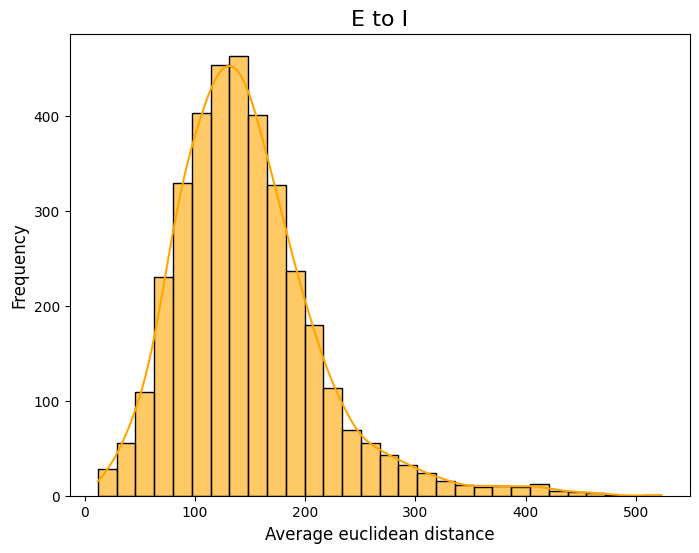

In [76]:
#Visualize euclidean distance distribution
#connectivity_ct_df_ecldn['euclidean_distance'].plot.hist(bins=5, color='orange', edgecolor='black')

plt.figure(figsize=(8, 6))
sns.histplot(queried_connectivity_ct_EI['avg_eucl_dist'], kde=True, bins=30, color='orange', alpha=0.6, edgecolor='black')

# Show the plot
# Add labels and title
plt.title('E to I', fontsize=16)
plt.xlabel('Average euclidean distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Save the figure as a PNG file
plt.savefig(f"/results/elcdn_EI.png", dpi=300)

plt.show()

In [39]:
# add the synaptic ratio - divide sum_size by number of synapses
queried_connectivity_ct_EI["syn_ratio"] = queried_connectivity_ct_EI["sum_size"]/queried_connectivity_ct_EI["total_synapses"]
queried_connectivity_ct_EI.head()

,pre_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,avg_eucl_dist,syn_ratio
0,864691132534275418,E,I,L4-IT,DTC,shaft,10,14,16331,125.008451,1166.500000
1,864691132534275418,E,I,L4-IT,PTC,shaft,5,5,7455,171.635147,1491.000000
2,864691132534275418,E,I,L4-IT,STC,shaft,1,1,508,296.058980,508.000000
3,864691132534315610,E,I,L4-IT,DTC,shaft,11,15,23641,135.643069,1576.066667
4,864691132534315610,E,I,L4-IT,DTC,spine,7,9,11368,149.559404,1263.111111


In [85]:
# add the synaptic ratio - divide sum_size by number of synapses
queried_connectivity_ct_EI_new["syn_ratio"] = queried_connectivity_ct_EI_new["sum_size"]/queried_connectivity_ct_EI_new["total_synapses"]
queried_connectivity_ct_EI_new.head()

,pre_pt_root_id,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,avg_eucl_dist,syn_ratio
0,864691132534275418,864691132619649223,E,I,L4-IT,DTC,shaft,1,1,2620,179.356591,2620.0
1,864691132534275418,864691132656860272,E,I,L4-IT,DTC,shaft,1,1,898,66.884140,898.0
2,864691132534275418,864691132659029623,E,I,L4-IT,DTC,shaft,1,3,3828,52.734229,1276.0
3,864691132534275418,864691132663898692,E,I,L4-IT,PTC,shaft,1,1,1556,322.189263,1556.0
4,864691132534275418,864691132689698824,E,I,L4-IT,DTC,shaft,1,1,1436,139.574497,1436.0


In [40]:
# Swap column 'syn_ratio' to the 8th position
col = queried_connectivity_ct_EI.pop('syn_ratio')
queried_connectivity_ct_EI.insert(9, 'syn_ratio', col)

queried_connectivity_ct_EI.head()

,pre_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,syn_ratio,avg_eucl_dist
0,864691132534275418,E,I,L4-IT,DTC,shaft,10,14,16331,1166.500000,125.008451
1,864691132534275418,E,I,L4-IT,PTC,shaft,5,5,7455,1491.000000,171.635147
2,864691132534275418,E,I,L4-IT,STC,shaft,1,1,508,508.000000,296.058980
3,864691132534315610,E,I,L4-IT,DTC,shaft,11,15,23641,1576.066667,135.643069
4,864691132534315610,E,I,L4-IT,DTC,spine,7,9,11368,1263.111111,149.559404


In [86]:
# Swap column 'syn_ratio' to the 8th position
col = queried_connectivity_ct_EI_new.pop('syn_ratio')
queried_connectivity_ct_EI_new.insert(10, 'syn_ratio', col)

queried_connectivity_ct_EI_new.head()

,pre_pt_root_id,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,syn_ratio,avg_eucl_dist
0,864691132534275418,864691132619649223,E,I,L4-IT,DTC,shaft,1,1,2620,2620.0,179.356591
1,864691132534275418,864691132656860272,E,I,L4-IT,DTC,shaft,1,1,898,898.0,66.884140
2,864691132534275418,864691132659029623,E,I,L4-IT,DTC,shaft,1,3,3828,1276.0,52.734229
3,864691132534275418,864691132663898692,E,I,L4-IT,PTC,shaft,1,1,1556,1556.0,322.189263
4,864691132534275418,864691132689698824,E,I,L4-IT,DTC,shaft,1,1,1436,1436.0,139.574497


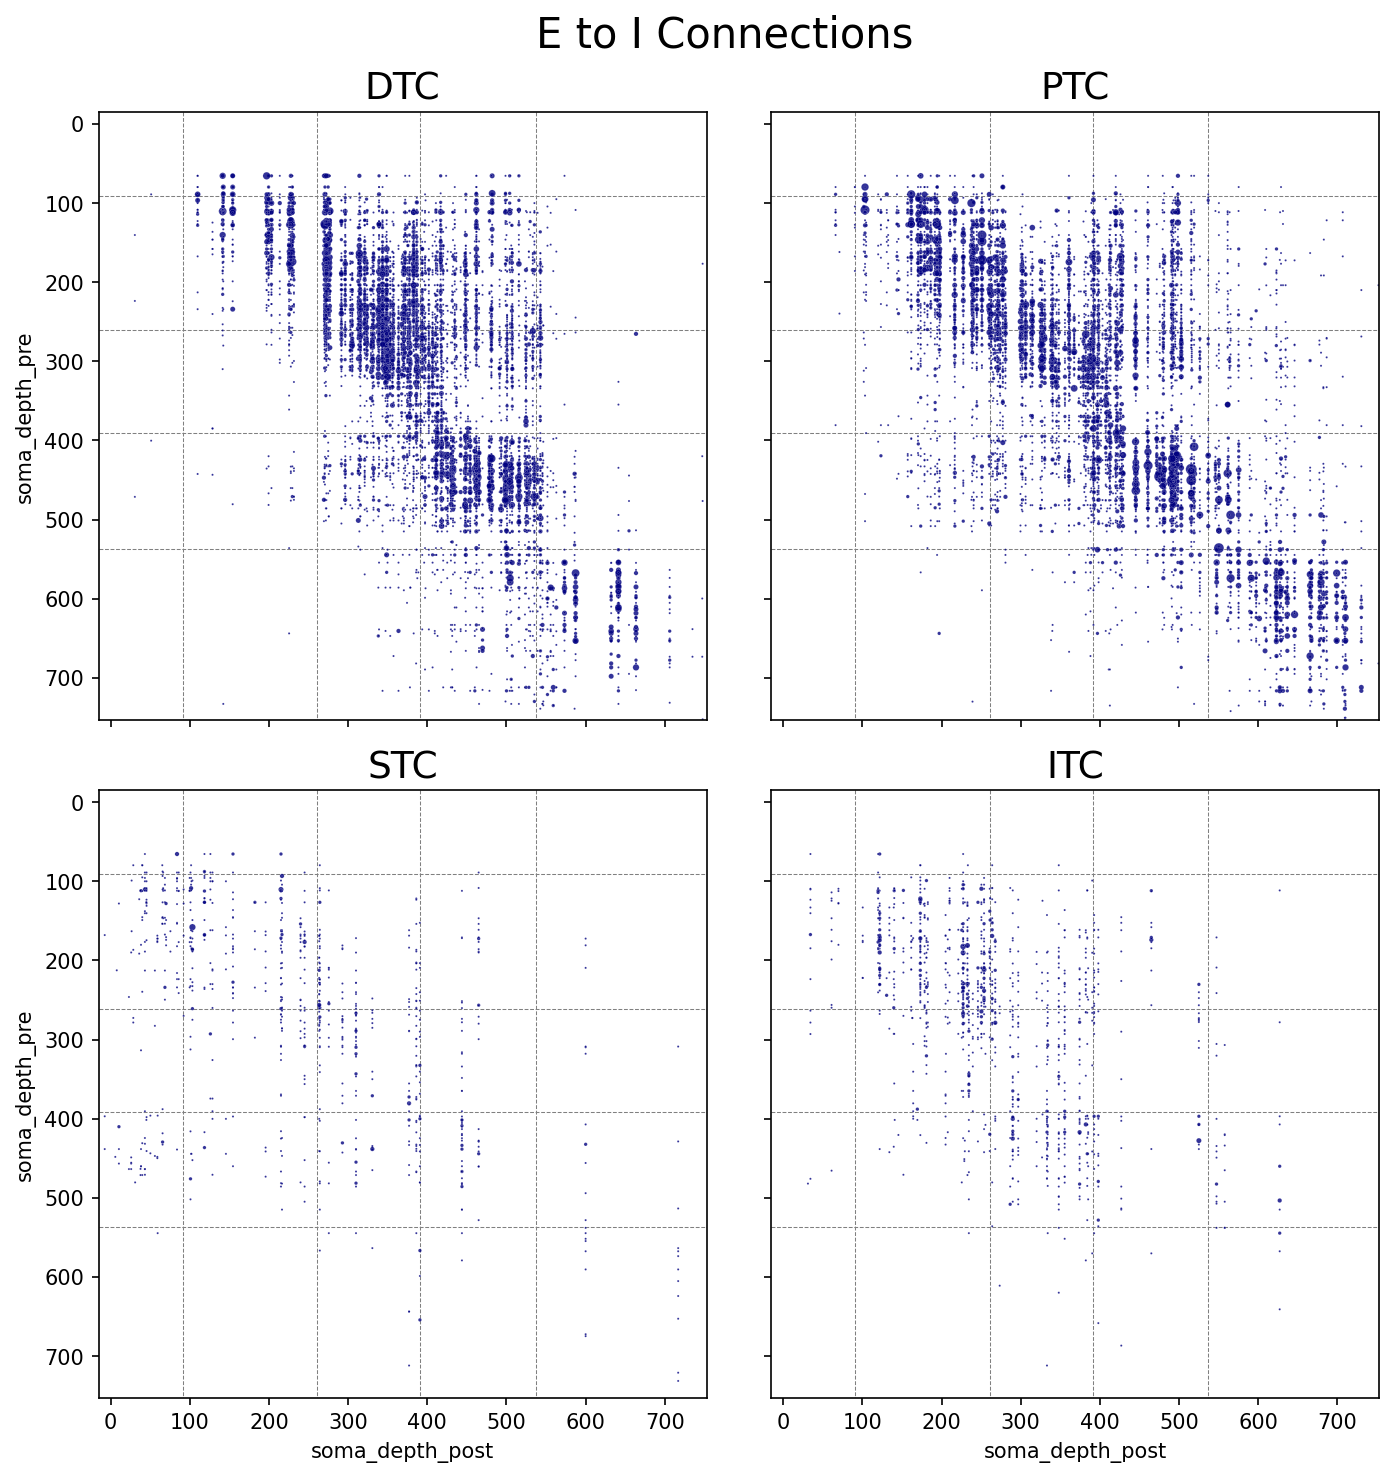

In [41]:
# visualize the EI synaptic connectivity across layer depth

fig, axes = plt.subplots(
    figsize=(10, 10),
    ncols=2,
    nrows=2,
    sharex=True,
    sharey=True,
    dpi=150,
    tight_layout=True,
)

ei_palette = {"E": "navy", "I": "tomato"}
ct_type = [["DTC", "PTC"], ["STC", "ITC"]]
#print(x)

for pre_ind in [0, 1]:
    for post_ind in [0, 1]:
        ax = axes[pre_ind, post_ind]
        #pre_cat = ct_category[pre_ind]
        #post_cat = ct_category[post_ind]
        cell_type = ct_type[pre_ind][post_ind]
        sns.scatterplot(
            data=connectivity_ct_IE_EI_mgd.query(
                'cell_type_post == @cell_type'
            ),
            x="soma_depth_post",
            y="soma_depth_pre",
            #hue="pre_pt_root_id",
            #data = connectivity_ct_df.query('ei_pre == "I" and ei_post == "E" and cell_type_post == @cell_type'),
            hue="ei_pre",
            ax=ax,
            size="num_synapses",
            sizes=(1, 50),
            size_norm=(1, 30),  # Sets the value range mapping to the range in "sizes".
            legend=False,
            palette=ei_palette,
            alpha=0.8,
        )

        ax.set_xlim(layer_bounds[0], layer_bounds[-1])
        ax.set_ylim(layer_bounds[0], layer_bounds[-1])
        ax.set_aspect("equal")

        ax.set_title(f"{cell_type}",fontsize = 18)

        # add horizontal and vertical lines where layers are
        ax.hlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )  # The `zorder` parameter puts the lines behind the scatter points
        ax.vlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )

ax.invert_yaxis()
plt.suptitle("E to I Connections", fontsize = 20)

# Save the figure as a PNG file
plt.savefig(f"/results/EtoI_synapticConnections.png")


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

##### Proportions of synapses onto target structures

In [45]:
group_structure_counts = connectivity_ct_IE_EI_mgd.groupby(
    ["cell_type_pre", "cell_type_post", "target_structure"],
    as_index=False,
).size()
group_structure_counts

,cell_type_pre,cell_type_post,target_structure,size
0,L2-IT,DTC,shaft,1246
1,L2-IT,DTC,soma,17
2,L2-IT,DTC,spine,603
3,L2-IT,ITC,shaft,228
4,L2-IT,ITC,spine,48
...,...,...,...,...
86,L6-IT,PTC,soma,24
87,L6-IT,PTC,spine,55
88,L6-IT,PTC,unknown,1
89,L6-IT,STC,shaft,17


In [46]:
group_total_counts = (
    group_structure_counts.groupby(["cell_type_pre", "cell_type_post"], as_index=False)[
        "size"
    ]
    .sum()
    .rename(columns={"size": "total_size"})
)

group_total_counts
# OR


,cell_type_pre,cell_type_post,total_size
0,L2-IT,DTC,1866
1,L2-IT,ITC,276
2,L2-IT,PTC,1536
3,L2-IT,STC,225
4,L3-IT,DTC,3979
5,L3-IT,ITC,480
6,L3-IT,PTC,2943
7,L3-IT,STC,242
8,L4-IT,DTC,1382
9,L4-IT,ITC,103


In [47]:
# merge the two group dataframes
group_counts = pd.merge(
    group_structure_counts,
    group_total_counts,
    on=["cell_type_pre", "cell_type_post"],
)
group_counts

,cell_type_pre,cell_type_post,target_structure,size,total_size
0,L2-IT,DTC,shaft,1246,1866
1,L2-IT,DTC,soma,17,1866
2,L2-IT,DTC,spine,603,1866
3,L2-IT,ITC,shaft,228,276
4,L2-IT,ITC,spine,48,276
...,...,...,...,...,...
86,L6-IT,PTC,soma,24,640
87,L6-IT,PTC,spine,55,640
88,L6-IT,PTC,unknown,1,640
89,L6-IT,STC,shaft,17,21


In [48]:
group_counts["proportion"] = group_counts["size"] / group_counts["total_size"]
group_counts

,cell_type_pre,cell_type_post,target_structure,size,total_size,proportion
0,L2-IT,DTC,shaft,1246,1866,0.667738
1,L2-IT,DTC,soma,17,1866,0.009110
2,L2-IT,DTC,spine,603,1866,0.323151
3,L2-IT,ITC,shaft,228,276,0.826087
4,L2-IT,ITC,spine,48,276,0.173913
...,...,...,...,...,...,...
86,L6-IT,PTC,soma,24,640,0.037500
87,L6-IT,PTC,spine,55,640,0.085938
88,L6-IT,PTC,unknown,1,640,0.001563
89,L6-IT,STC,shaft,17,21,0.809524


In [49]:
# to make our plot look nicer, this code just reorders the categories to be first by
# excitatory/inhibitory, then by layer, and finally by cell type
categories = [
    "L2-IT",  # excitatory cell types
    "L3-IT",
    "L4-IT",
    "L5-IT",
    "L5-ET",
    "L5-NP",
    "L6-IT",
    "L6-CT",
    "DTC",  # inhibitory cell types
    "ITC",
    "PTC",
    "STC",
]

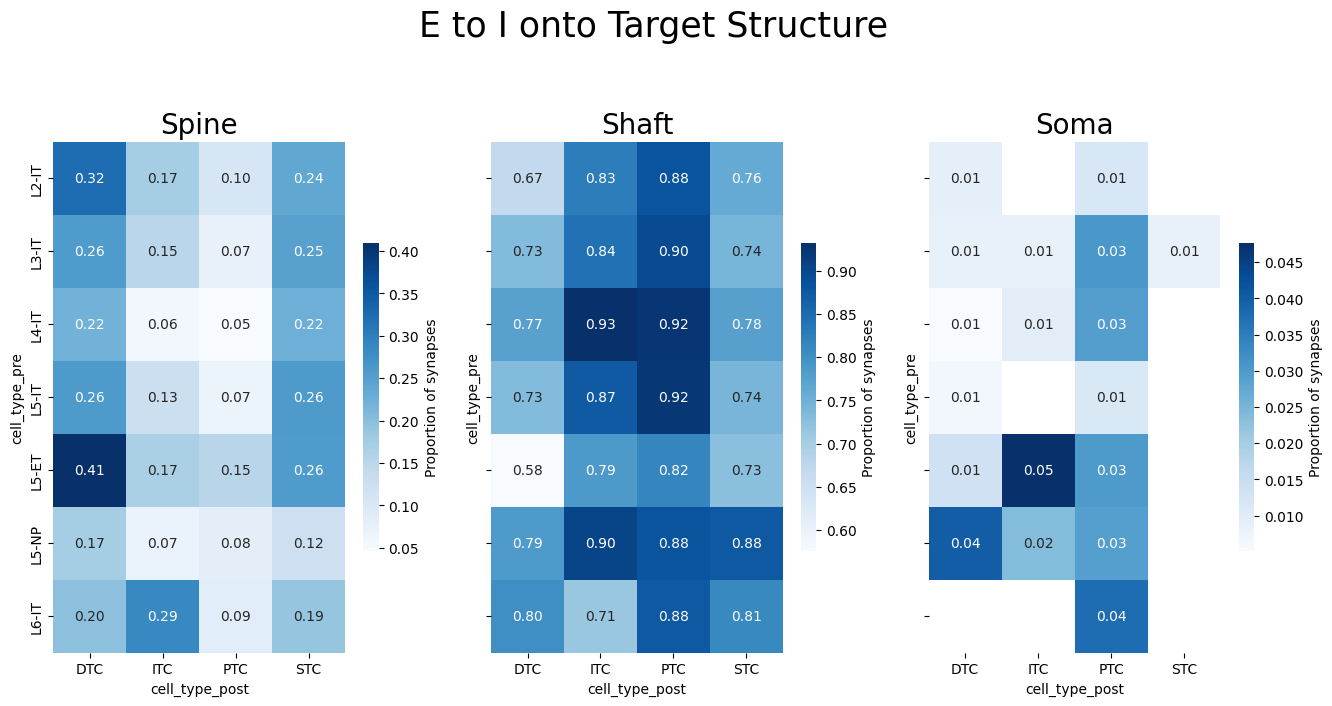

In [79]:
fig, axs = plt.subplots(1, 3, figsize=(16,8), sharey=True) #, layout="constrained")

for i, target_structure in enumerate(["spine", "shaft", "soma"]):
    square_counts = group_counts.query(
        f"target_structure == '{target_structure}'"
    ).pivot(index="cell_type_pre", columns="cell_type_post", values="proportion")

    square_counts = square_counts.reindex(index=categories[:7], columns=categories[-4:])

    sns.heatmap(
        square_counts,
        annot=True,
        cmap="Blues",
        ax=axs[i],
        square=True,
        cbar= True, #(i == len(axs) - 1), 
        #cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4]),
        #cbar_ax=None if i < len(axes) - 1 else fig.add_axes([0.92, 0.3, 0.02, 0.4]),
        cbar_kws= {"label": "Proportion of synapses", 'shrink': 0.5},
        #None if i < len(axes) - 1 else {"label": "Proportion of synapses", 'shrink': 0.5},
        fmt=".2f",  # format the annotations to 2 decimal places
    )
    
    axs[i].set_title(target_structure.capitalize(),fontsize = 20)
 
'''
# Add a single colorbar
#cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
#fig.colorbar(axs[0].collections[0], cax=cbar_ax)

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
cbar = fig.colorbar(axs[1].collections[0], ax=axs, orientation='vertical',
                    label = "Proportion of synapses" ,
                    fraction=0.02, pad=0.04, shrink = 0.5)
'''

#axs[2].set_cbar_kws({"label": "Proportion of synapses onto " + target_structure})
plt.suptitle("E to I onto Target Structure", fontsize = 25)

# Save the figure as a PNG file
plt.savefig(f"/results/E2I_targetStructure.png")

In [87]:
# save the IE and EI data 

#queried_connectivity_ct_IE.to_feather(f"/data/IE_struct_cell_tbl_v1dd_{mat_version}.feather",
                                      #compression="zstd")
queried_connectivity_ct_EI.to_feather(f"/data/new_EI_struct_cell_tbl_v1dd_{mat_version}.feather",
                                      compression="zstd")

queried_connectivity_ct_EI_new.to_feather(f"/data/EI_new_v1dd_{mat_version}.feather",
                                      compression="zstd")

#queried_connectivity_ct_EI
#np.save(f"{data_dir}/proofread_axon_list_{mat_version}.npy", axon_proof_root_ids)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

#### E to E connections


In [74]:
# find E to E connections

connectivity_ct_EE = connectivity_ct_df.query('ei_pre == "E" and ei_post == "E"')
connectivity_ct_EE.head()

,pre_pt_root_id,post_pt_root_id,num_synapses,sum_size,synaptic_ratio,target_structure,soma_depth_pre,ei_pre,cell_type_pre,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,soma_depth_post,ei_post,cell_type_post,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,euclidean_distance
3,864691132534275418,864691132663192644,1,4488,4488.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,480.704383,E,L5-ET,-125.287543,480.704383,-41.081802,187.619025
5,864691132534275418,864691132666054744,1,4965,4965.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,465.692836,E,L5-ET,-128.831488,465.692836,-19.084771,164.731247
7,864691132534275418,864691132700001158,1,631,631.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,427.743622,E,L5-ET,-113.338277,427.743622,54.040920,120.566079
9,864691132534275418,864691132739485851,1,3425,3425.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,436.666528,E,L5-ET,-23.587578,436.666528,61.123783,177.482733
10,864691132534275418,864691132739804244,1,1692,1692.0,spine,313.619432,E,L4-IT,-149.843152,313.619432,40.652767,303.193972,E,L4-IT,-36.940238,303.193972,-59.283195,151.138858


In [105]:
# Count the number of each E postsynaaptic cell type connection
# query dataframe to count the number of E cell connections
queried_connectivity_ct_EE = (
    connectivity_ct_EE.groupby(["pre_pt_root_id","ei_pre","ei_post","cell_type_pre","cell_type_post","target_structure"])
    .agg(num_connections=("cell_type_post", "count"),
        total_synapses=("num_synapses", "sum"),
         sum_size = ("sum_size", "sum"),
         #syn_ratio = ("synaptic_ratio", "mean"),
         avg_eucl_dist = ("euclidean_distance", "mean")
         )
    .reset_index()  
)

queried_connectivity_ct_EE.head()

,pre_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,avg_eucl_dist
0,864691132534275418,E,E,L4-IT,L3-IT,spine,1,1,1544,93.704969
1,864691132534275418,E,E,L4-IT,L4-IT,spine,2,2,2822,160.187883
2,864691132534275418,E,E,L4-IT,L5-ET,spine,6,6,14096,168.801540
3,864691132534275418,E,E,L4-IT,L5-IT,spine,2,2,8695,149.357230
4,864691132534315610,E,E,L4-IT,L3-IT,shaft,1,1,160,90.222170


In [106]:
# Count the number of each E postsynaaptic cell type connection
# query dataframe to count the number of E cell connections
queried_connectivity_ct_EE_new = (
    connectivity_ct_EE.groupby(["pre_pt_root_id", "post_pt_root_id","ei_pre","ei_post","cell_type_pre","cell_type_post","target_structure"])
    .agg(num_connections=("cell_type_post", "count"),
        total_synapses=("num_synapses", "sum"),
         sum_size = ("sum_size", "sum"),
         #syn_ratio = ("synaptic_ratio", "mean"),
         avg_eucl_dist = ("euclidean_distance", "mean")
         )
    .reset_index()  
)

queried_connectivity_ct_EE_new.head()

,pre_pt_root_id,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,avg_eucl_dist
0,864691132534275418,864691132663192644,E,E,L4-IT,L5-ET,spine,1,1,4488,187.619025
1,864691132534275418,864691132666054744,E,E,L4-IT,L5-ET,spine,1,1,4965,164.731247
2,864691132534275418,864691132700001158,E,E,L4-IT,L5-ET,spine,1,1,631,120.566079
3,864691132534275418,864691132739485851,E,E,L4-IT,L5-ET,spine,1,1,3425,177.482733
4,864691132534275418,864691132739804244,E,E,L4-IT,L4-IT,spine,1,1,1692,151.138858


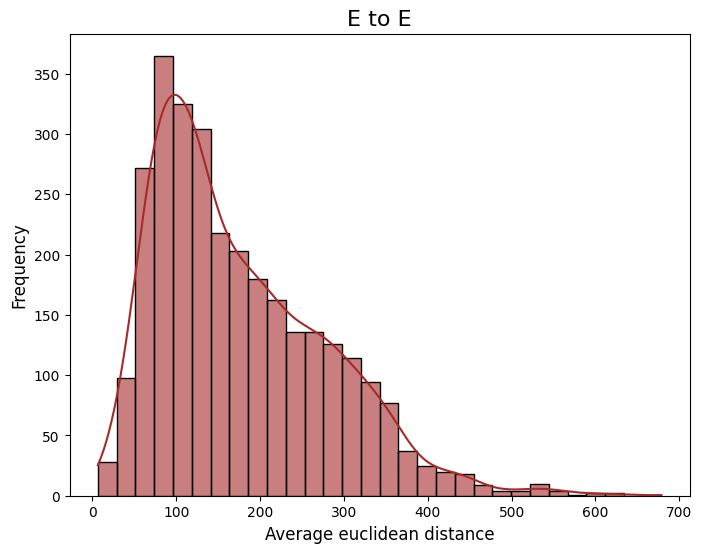

In [80]:
#Visualize euclidean distance distribution
#connectivity_ct_df_ecldn['euclidean_distance'].plot.hist(bins=5, color='orange', edgecolor='black')

plt.figure(figsize=(8, 6))
sns.histplot(queried_connectivity_ct_EE['avg_eucl_dist'], kde=True, bins=30, color='brown', alpha=0.6, edgecolor='black')

# Show the plot
# Add labels and title
plt.title('E to E', fontsize=16)
plt.xlabel('Average euclidean distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Save the figure as a PNG file
plt.savefig(f"/results/elcdn_EE.png", dpi=300)

plt.show()

In [107]:
# add the synaptic ratio - divide sum_size by number of synapses
queried_connectivity_ct_EE["syn_ratio"] = queried_connectivity_ct_EE["sum_size"]/queried_connectivity_ct_EE["total_synapses"]
queried_connectivity_ct_EE.head()

,pre_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,avg_eucl_dist,syn_ratio
0,864691132534275418,E,E,L4-IT,L3-IT,spine,1,1,1544,93.704969,1544.000000
1,864691132534275418,E,E,L4-IT,L4-IT,spine,2,2,2822,160.187883,1411.000000
2,864691132534275418,E,E,L4-IT,L5-ET,spine,6,6,14096,168.801540,2349.333333
3,864691132534275418,E,E,L4-IT,L5-IT,spine,2,2,8695,149.357230,4347.500000
4,864691132534315610,E,E,L4-IT,L3-IT,shaft,1,1,160,90.222170,160.000000


In [108]:
# add the synaptic ratio - divide sum_size by number of synapses
queried_connectivity_ct_EE_new["syn_ratio"] = queried_connectivity_ct_EE_new["sum_size"]/queried_connectivity_ct_EE_new["total_synapses"]
queried_connectivity_ct_EE_new.head()

,pre_pt_root_id,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,avg_eucl_dist,syn_ratio
0,864691132534275418,864691132663192644,E,E,L4-IT,L5-ET,spine,1,1,4488,187.619025,4488.0
1,864691132534275418,864691132666054744,E,E,L4-IT,L5-ET,spine,1,1,4965,164.731247,4965.0
2,864691132534275418,864691132700001158,E,E,L4-IT,L5-ET,spine,1,1,631,120.566079,631.0
3,864691132534275418,864691132739485851,E,E,L4-IT,L5-ET,spine,1,1,3425,177.482733,3425.0
4,864691132534275418,864691132739804244,E,E,L4-IT,L4-IT,spine,1,1,1692,151.138858,1692.0


In [109]:
# Swap column 'syn_ratio' to the 8th position
col = queried_connectivity_ct_EE.pop('syn_ratio')
queried_connectivity_ct_EE.insert(9, 'syn_ratio', col)

queried_connectivity_ct_EE.head()

,pre_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,syn_ratio,avg_eucl_dist
0,864691132534275418,E,E,L4-IT,L3-IT,spine,1,1,1544,1544.000000,93.704969
1,864691132534275418,E,E,L4-IT,L4-IT,spine,2,2,2822,1411.000000,160.187883
2,864691132534275418,E,E,L4-IT,L5-ET,spine,6,6,14096,2349.333333,168.801540
3,864691132534275418,E,E,L4-IT,L5-IT,spine,2,2,8695,4347.500000,149.357230
4,864691132534315610,E,E,L4-IT,L3-IT,shaft,1,1,160,160.000000,90.222170


In [110]:
# Swap column 'syn_ratio' to the 8th position
col = queried_connectivity_ct_EE_new.pop('syn_ratio')
queried_connectivity_ct_EE_new.insert(10, 'syn_ratio', col)

queried_connectivity_ct_EE_new.head()

,pre_pt_root_id,post_pt_root_id,ei_pre,ei_post,cell_type_pre,cell_type_post,target_structure,num_connections,total_synapses,sum_size,syn_ratio,avg_eucl_dist
0,864691132534275418,864691132663192644,E,E,L4-IT,L5-ET,spine,1,1,4488,4488.0,187.619025
1,864691132534275418,864691132666054744,E,E,L4-IT,L5-ET,spine,1,1,4965,4965.0,164.731247
2,864691132534275418,864691132700001158,E,E,L4-IT,L5-ET,spine,1,1,631,631.0,120.566079
3,864691132534275418,864691132739485851,E,E,L4-IT,L5-ET,spine,1,1,3425,3425.0,177.482733
4,864691132534275418,864691132739804244,E,E,L4-IT,L4-IT,spine,1,1,1692,1692.0,151.138858


In [83]:
connectivity_ct_EE["cell_type_pre"].value_counts()

cell_type_pre
L3-IT    2753
L2-IT    1783
L4-IT    1386
L5-IT    1334
L5-ET     539
L5-NP     388
L6-IT     297
L6-CT     140
Name: count, dtype: int64

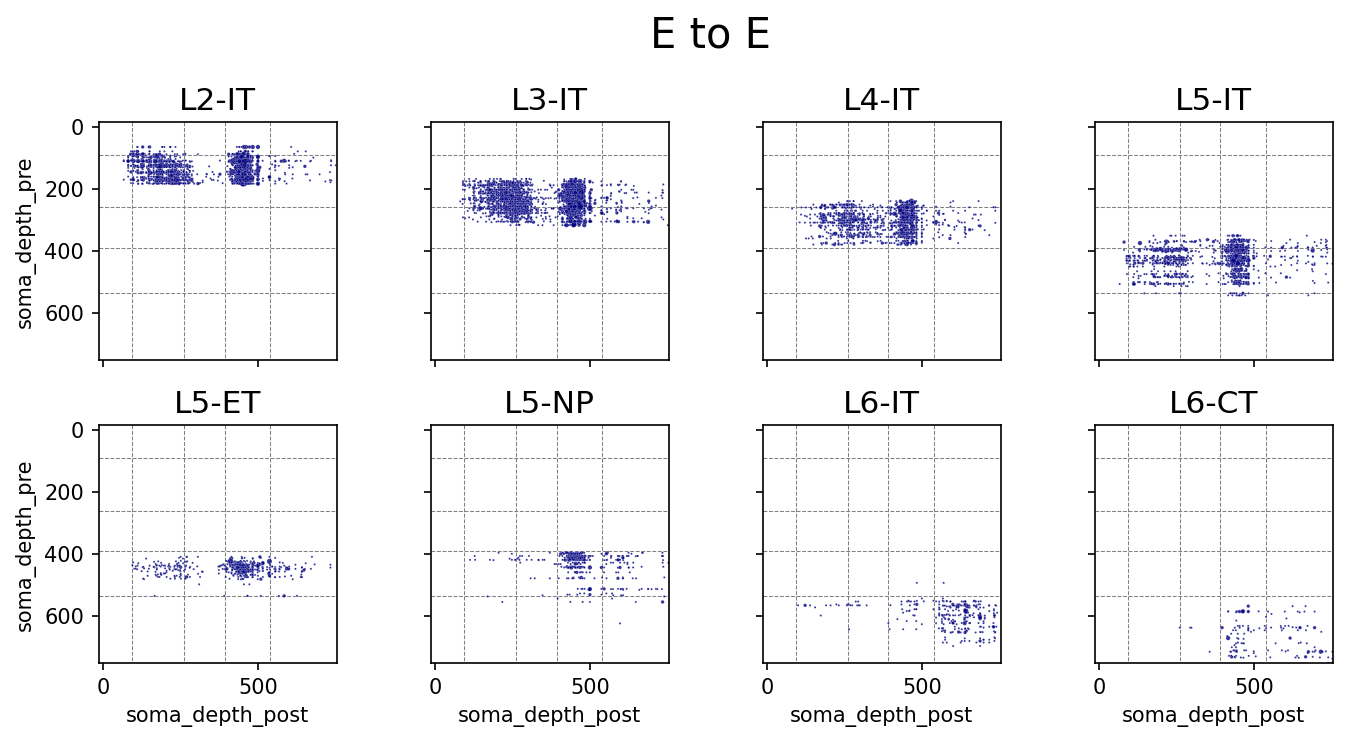

In [101]:
# visualize the EE synaptic connectivity across layer depth

fig, axes = plt.subplots(
    figsize=(10, 5),
    ncols=4,
    nrows=2,
    sharex=True,
    sharey=True,
    dpi=150,
    tight_layout=True,
)

ie_palette = {"I": "tomato", "E": "navy"}
ct_type = [["L2-IT", "L3-IT","L4-IT", "L5-IT"],
          ["L5-ET", "L5-NP", "L6-IT", "L6-CT"]]
#print(x)

for pre_ind in [0, 1]:
    for post_ind in [0, 1, 2,3]:
        ax = axes[pre_ind, post_ind]
        #pre_cat = ct_category[pre_ind]
        #post_cat = ct_category[post_ind]
        cell_type = ct_type[pre_ind][post_ind]
        sns.scatterplot(
            data=connectivity_ct_EE.query(
                'cell_type_pre == @cell_type'
            ),
            x="soma_depth_post",
            y="soma_depth_pre",
            #hue="pre_pt_root_id",
            #data = connectivity_ct_df.query('ei_pre == "I" and ei_post == "E" and cell_type_post == @cell_type'),
            hue="ei_pre",
            ax=ax,
            size="num_synapses",
            sizes=(1, 50),
            size_norm=(1, 30),  # Sets the value range mapping to the range in "sizes".
            legend=False,
            palette=ie_palette,
            alpha=0.8,
        )

        ax.set_xlim(layer_bounds[0], layer_bounds[-1])
        ax.set_ylim(layer_bounds[0], layer_bounds[-1])
        ax.set_aspect("equal")

        ax.set_title(f"{cell_type}",fontsize = 15)

        # add horizontal and vertical lines where layers are
        ax.hlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )  # The `zorder` parameter puts the lines behind the scatter points
        ax.vlines(
            layer_bounds[1:],
            layer_bounds[0],
            layer_bounds[-1],
            color="gray",
            linestyle="--",
            linewidth=0.5,
            zorder=-10,
        )

ax.invert_yaxis()
plt.suptitle("E to E", fontsize = 20)

# Save the figure as a PNG file
plt.savefig(f"/results/EtoE_synapticConnections.png")


In [88]:
ct_type = [["L2-IT", "L3-IT"], ["L4-IT", "L5-IT"],
          ["L5-ET", "L5-NP"], ["L6-IT", "L6-CT"]]

In [93]:
ct_type[3][0]

'L6-IT'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;">

##### Proportions of synapses onto target structures

In [113]:
group_structure_counts = connectivity_ct_EE.groupby(
    ["cell_type_pre", "cell_type_post", "target_structure"],
    as_index=False,
).size()
group_structure_counts

,cell_type_pre,cell_type_post,target_structure,size
0,L2-IT,L2-IT,shaft,37
1,L2-IT,L2-IT,soma,2
2,L2-IT,L2-IT,spine,383
3,L2-IT,L3-IT,shaft,35
4,L2-IT,L3-IT,soma,1
...,...,...,...,...
133,L6-IT,L5-NP,spine,1
134,L6-IT,L6-CT,shaft,5
135,L6-IT,L6-CT,spine,100
136,L6-IT,L6-IT,shaft,15


In [114]:
group_total_counts = (
    group_structure_counts.groupby(["cell_type_pre", "cell_type_post"], as_index=False)[
        "size"
    ]
    .sum()
    .rename(columns={"size": "total_size"})
)

group_total_counts
# OR


,cell_type_pre,cell_type_post,total_size
0,L2-IT,L2-IT,422
1,L2-IT,L3-IT,499
2,L2-IT,L4-IT,22
3,L2-IT,L5-ET,669
4,L2-IT,L5-IT,109
...,...,...,...
58,L6-IT,L5-ET,25
59,L6-IT,L5-IT,10
60,L6-IT,L5-NP,2
61,L6-IT,L6-CT,105


In [115]:
# merge the two group dataframes
group_counts = pd.merge(
    group_structure_counts,
    group_total_counts,
    on=["cell_type_pre", "cell_type_post"],
)
group_counts

,cell_type_pre,cell_type_post,target_structure,size,total_size
0,L2-IT,L2-IT,shaft,37,422
1,L2-IT,L2-IT,soma,2,422
2,L2-IT,L2-IT,spine,383,422
3,L2-IT,L3-IT,shaft,35,499
4,L2-IT,L3-IT,soma,1,499
...,...,...,...,...,...
133,L6-IT,L5-NP,spine,1,2
134,L6-IT,L6-CT,shaft,5,105
135,L6-IT,L6-CT,spine,100,105
136,L6-IT,L6-IT,shaft,15,134


In [116]:
group_counts["proportion"] = group_counts["size"] / group_counts["total_size"]
group_counts

,cell_type_pre,cell_type_post,target_structure,size,total_size,proportion
0,L2-IT,L2-IT,shaft,37,422,0.087678
1,L2-IT,L2-IT,soma,2,422,0.004739
2,L2-IT,L2-IT,spine,383,422,0.907583
3,L2-IT,L3-IT,shaft,35,499,0.070140
4,L2-IT,L3-IT,soma,1,499,0.002004
...,...,...,...,...,...,...
133,L6-IT,L5-NP,spine,1,2,0.500000
134,L6-IT,L6-CT,shaft,5,105,0.047619
135,L6-IT,L6-CT,spine,100,105,0.952381
136,L6-IT,L6-IT,shaft,15,134,0.111940


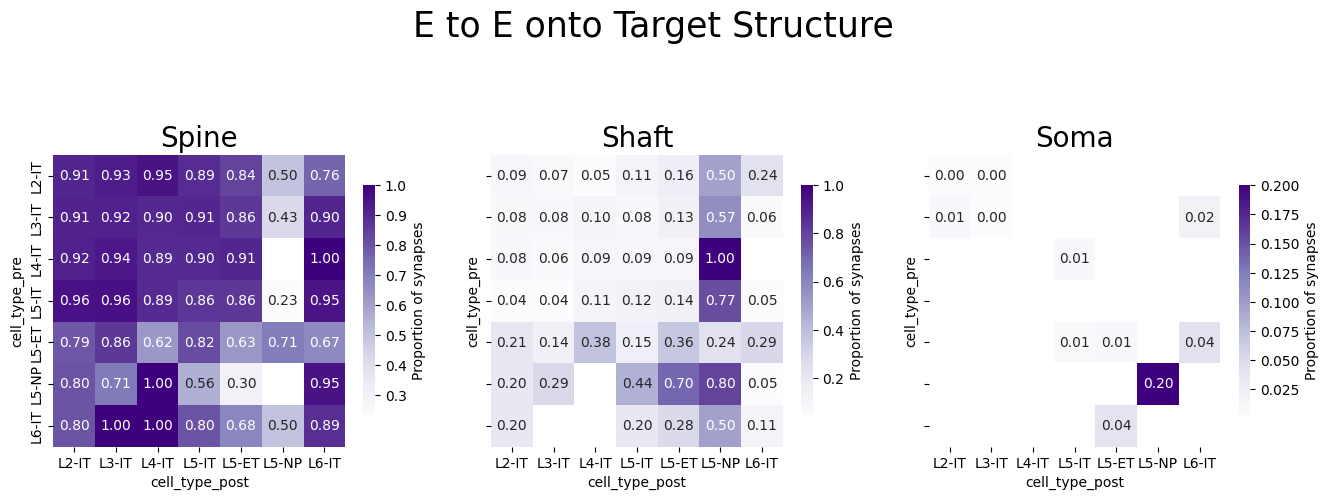

In [129]:
fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True) #, layout="constrained")

for i, target_structure in enumerate(["spine", "shaft", "soma"]):
    square_counts = group_counts.query(
        f"target_structure == '{target_structure}'"
    ).pivot(index="cell_type_pre", columns="cell_type_post", values="proportion")

    square_counts = square_counts.reindex(index=categories[:7], columns=categories[:7])

    sns.heatmap(
        square_counts,
        annot=True,
        cmap='Purples',
        ax=axs[i],
        square=True,
        cbar= True, #(i == len(axs) - 1), 
        #cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4]),
        #cbar_ax=None if i < len(axes) - 1 else fig.add_axes([0.92, 0.3, 0.02, 0.4]),
        cbar_kws= {"label": "Proportion of synapses", 'shrink': 0.5},
        #None if i < len(axes) - 1 else {"label": "Proportion of synapses", 'shrink': 0.5},
        fmt=".2f",  # format the annotations to 2 decimal places
    )
    
    axs[i].set_title(target_structure.capitalize(),fontsize = 20)
 
'''
# Add a single colorbar
#cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
#fig.colorbar(axs[0].collections[0], cax=cbar_ax)

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
cbar = fig.colorbar(axs[1].collections[0], ax=axs, orientation='vertical',
                    label = "Proportion of synapses" ,
                    fraction=0.02, pad=0.04, shrink = 0.5)
'''

#axs[2].set_cbar_kws({"label": "Proportion of synapses onto " + target_structure})
plt.suptitle("E to E onto Target Structure", fontsize = 25)

# Save the figure as a PNG file
plt.savefig(f"/results/EE_targetStructure.png")

In [111]:
# save the IE and EI data 

#queried_connectivity_ct_IE.to_feather(f"/data/IE_struct_cell_tbl_v1dd_{mat_version}.feather",
                                      #compression="zstd")
queried_connectivity_ct_EE.to_feather(f"/data/EE_struct_cell_tbl_v1dd_{mat_version}.feather",
                                      compression="zstd")

queried_connectivity_ct_EE_new.to_feather(f"/data/new_EE_v1dd_{mat_version}.feather",
                                      compression="zstd")

#queried_connectivity_ct_EI
#np.save(f"{data_dir}/proofread_axon_list_{mat_version}.npy", axon_proof_root_ids)


In [117]:
plt.colormaps()

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'berlin',
 'managua',
 'vanimo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',